In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import folium
from scipy import stats

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM

In [3]:
dtypes = {
    'mapped_veh_id': 'int32',
    'RS_E_InAirTemp_PC1': 'float32',
    'RS_E_InAirTemp_PC2': 'float32',
    'RS_E_OilPress_PC1': 'float32',
    'RS_E_OilPress_PC2': 'float32',
    'RS_E_RPM_PC1': 'float32',
    'RS_E_RPM_PC2': 'float32',
    'RS_E_WatTemp_PC1': 'float32',
    'RS_E_WatTemp_PC2': 'float32',
    'RS_T_OilTemp_PC1': 'float32',
    'RS_T_OilTemp_PC2': 'float32',
    'temp':'float32',
    'elevation':'float32'
}

data = pd.read_csv('ar41_data.csv', delimiter=',', dtype=dtypes)
data

,Unnamed: 0,mapped_veh_id,timestamps_UTC,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,...,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2,temp,weather,weather_description,elevation,timestamps_Belgian,time_diff_overall
0,5493376,102,2023-01-23 07:25:08+00:00,51.017864,3.769079,17.0,18.0,210.0,210.0,858.0,...,78.0,80.0,71.0,79.0,1.380000,clouds,overcast clouds,13.0,2023-01-23 08:25:08+00:00,0.0
1,8969009,102,2023-01-23 07:25:16+00:00,51.017875,3.769046,17.0,20.0,200.0,200.0,801.0,...,79.0,80.0,76.0,79.0,1.380000,clouds,overcast clouds,13.0,2023-01-23 08:25:16+00:00,8.0
2,13873566,102,2023-01-23 07:25:37+00:00,51.017208,3.770179,19.0,20.0,193.0,207.0,803.0,...,80.0,81.0,79.0,81.0,1.380000,clouds,overcast clouds,12.0,2023-01-23 08:25:37+00:00,21.0
3,14994675,102,2023-01-23 07:25:41+00:00,51.016916,3.771036,19.0,20.0,196.0,203.0,801.0,...,80.0,81.0,79.0,81.0,1.380000,clouds,overcast clouds,12.0,2023-01-23 08:25:41+00:00,4.0
4,11935795,102,2023-01-23 07:26:10+00:00,51.016503,3.772182,19.0,21.0,200.0,203.0,795.0,...,80.0,82.0,79.0,79.0,1.380000,clouds,overcast clouds,13.0,2023-01-23 08:26:10+00:00,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17679234,1820536,197,2023-09-13 17:33:03+00:00,50.402693,4.450111,37.0,40.0,220.0,258.0,803.0,...,81.0,79.0,77.0,81.0,18.950001,clouds,few clouds,104.0,2023-09-13 19:33:03+00:00,5.0
17679235,17128255,197,2023-09-13 17:33:58+00:00,50.401657,4.452693,37.0,38.0,224.0,307.0,843.0,...,80.0,78.0,77.0,80.0,18.950001,clouds,few clouds,105.0,2023-09-13 19:33:58+00:00,55.0
17679236,15456252,197,2023-09-13 17:34:03+00:00,50.401830,4.452217,37.0,38.0,224.0,307.0,841.0,...,80.0,78.0,77.0,80.0,18.950001,clouds,few clouds,105.0,2023-09-13 19:34:03+00:00,5.0
17679237,7666957,197,2023-09-13 17:34:58+00:00,50.401057,4.455388,36.0,38.0,207.0,244.0,800.0,...,81.0,80.0,77.0,82.0,18.950001,clouds,few clouds,99.0,2023-09-13 19:34:58+00:00,55.0


In [4]:
columns_to_check = ['RS_E_InAirTemp_PC2', 'RS_E_OilPress_PC2', 'RS_E_RPM_PC2', 'RS_E_WatTemp_PC2', 'RS_T_OilTemp_PC2']
data.dropna(subset=columns_to_check, inplace=True)
data.drop(['Unnamed: 0', 'timestamps_UTC'], axis=1, inplace=True)

In [5]:
def calculate_speed(df, lat_col='lat', lon_col='lon', time_diff_col='time_diff_overall', veh_id_col='mapped_veh_id', journey_id_col='journey_id'):
    def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
        if to_radians:
            lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

        a = np.sin((lat2 - lat1) / 2.0)**2 + \
            np.cos(lat1) * np.cos(lat2) * np.sin((lon2 - lon1) / 2.0)**2

        return earth_radius * 2 * np.arcsin(np.sqrt(a))
    # Calculate the speed of a train in km/h between successive rows, grouped by train and journey_id.
    def calculate_group_speed(group):
        # Calculate the distance for each group
        group['distance'] = haversine(group[lat_col].shift(), group[lon_col].shift(), group[lat_col], group[lon_col])
        # Calculate speed in km/h, avoid division by zero
        group['speed'] = np.where(group[time_diff_col] > 0, (group['distance'] / group[time_diff_col]) * 3600, np.nan)
        # Handle the first entry of each group
        group['speed'].iloc[0] = 0
        group['distance'].iloc[0] = 0
        return group    
    # Group by vehicle id and journey id, then apply the speed calculation
    df = df.groupby([veh_id_col], as_index=False).apply(calculate_group_speed)
    df = df.reset_index(drop=True)
    return df

def divide_journeys(data, time_threshold_1=300, time_threshold_2=600, speed_threshold = 0.5):
    condition = (data['time_diff_overall'] >= time_threshold_1) & \
                (data['speed'] < speed_threshold) | \
                (data['time_diff_overall'] >= time_threshold_2)
    data['time_diff'] = data['time_diff_overall'].where(~condition, 0).astype(int)
    data['new_journey'] = (data['time_diff'] == 0).astype(int)
    data['journey_id'] = data.groupby('mapped_veh_id')['new_journey'].cumsum()
    data.drop('new_journey', axis=1, inplace=True)    
    
data = calculate_speed(data)
divide_journeys(data)

In [ ]:
data.head(5)

In [6]:
def rolling_operation(x):
    return x.rolling(window=2).mean().bfill().ffill()
data['rolling_avg_speed'] = data.groupby(['mapped_veh_id', 'journey_id'])['speed'].transform(rolling_operation)
data['rolling_avg_speed'] = data['rolling_avg_speed'].fillna(data['speed'])

## Data Cleaning

In [7]:
data.shape[0]

17666513

In [8]:
data['timestamps_Belgian'] = pd.to_datetime(data['timestamps_Belgian'])
data['hour'] = data['timestamps_Belgian'].dt.hour
events_per_hour = data['hour'].value_counts().sort_index()
print(events_per_hour)

indices_to_drop = data[(data['hour'] >= 1) & (data['hour'] < 5)].index
# Drop these rows in-place
data.drop(indices_to_drop, inplace=True)
data.shape[0]

0      250579
1      275744
2      350047
3      491818
4      783420
5      931471
6      995008
7     1022997
8      989904
9      912654
10     851323
11     813290
12     770148
13     807437
14     865046
15     970731
16    1024691
17    1006206
18     867617
19     707943
20     608023
21     539128
22     474593
23     356695
Name: hour, dtype: int64


15765484

In [9]:
# Find cases where both the engines are stopped.
condition = (data['RS_E_RPM_PC1'] < 100) & (data['RS_E_RPM_PC2'] < 100)
n_subsequent_rows = 4
# Create the 'ConditionSum' column
data['ConditionSum'] = condition.rolling(window=n_subsequent_rows).sum()
# Filter the DataFrame in-place
data.drop(data[data['ConditionSum'] >= n_subsequent_rows].index, inplace=True)
# Drop the 'ConditionSum' column
data.drop(columns=['ConditionSum'], inplace=True)
data.shape[0]

15351765

## PCA

In [10]:
# Select relevant features
features = data[['RS_E_InAirTemp_PC1', 'RS_E_OilPress_PC1', 'RS_E_RPM_PC1', 'RS_E_WatTemp_PC1', 'RS_T_OilTemp_PC1', 'RS_E_InAirTemp_PC2', 'RS_E_OilPress_PC2', 'RS_E_RPM_PC2', 'RS_E_WatTemp_PC2', 'RS_T_OilTemp_PC2', 'rolling_avg_speed']]

# Normalize features
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

In [14]:
# Select relevant features
features = data[['RS_E_InAirTemp_PC1', 'RS_E_OilPress_PC1', 'RS_E_RPM_PC1', 'RS_E_WatTemp_PC1', 'RS_T_OilTemp_PC1', 'RS_E_InAirTemp_PC2', 'RS_E_OilPress_PC2', 'RS_E_RPM_PC2', 'RS_E_WatTemp_PC2', 'RS_T_OilTemp_PC2', 'rolling_avg_speed']]

# Normalize features
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

# Apply PCA
pca = PCA()  # Adjust the number of components based on your PCA analysis
features_pca = pca.fit_transform(features_normalized)

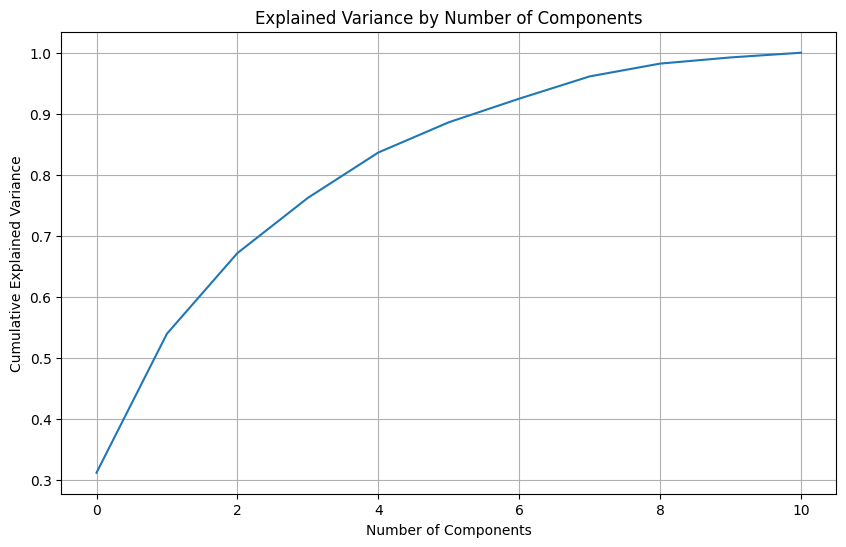

In [15]:
# Number of components in PCA
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.grid(True)
plt.show()

In [11]:
# New model with decided number of components. For now n_components=4
pca = PCA(n_components=4)
features_pca = pca.fit_transform(features_normalized)

## Isolation Forest

In [12]:
# Instantiate and fit the Isolation Forest model
model = IsolationForest(n_estimators=1000, max_samples='auto', contamination='auto', random_state=42)
model.fit(features_pca)

# Predict anomalies using PCA transformed features
anomaly_predictions = model.predict(features_pca)
data.loc[data.index, 'anomaly_iso'] = anomaly_predictions

# Check the anomaly count
anomaly_count = data['anomaly__iso'].value_counts()
anomaly_count

KeyError: 'anomaly__iso'

In [13]:
# Check the anomaly count
anomaly_count = data['anomaly_iso'].value_counts()
anomaly_count

 1    13095383
-1     2256382
Name: anomaly_iso, dtype: int64

In [14]:
data.to_csv('isolation.csv', index=False)

## One Class SVM

In [1]:
# Instantiate and fit the One-Class SVM model
# The nu parameter is an upper bound on the fraction of training errors and a lower bound of the fraction of support vectors.
# Kernel choice ('rbf', 'linear', etc.) and other hyperparameters should be chosen based on your specific dataset and requirements.
oc_svm_model = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
oc_svm_model.fit(features_pca)

# Predict anomalies
# The One-Class SVM predicts -1 for anomalies and 1 for normal observations
anomaly_predictions = oc_svm_model.predict(features_pca)
# Mapping -1 to 1 for anomaly and 1 to 0 for normal for consistency with Isolation Forest
data.loc[data.index, 'anomaly_svm'] = anomaly_predictions

# Check the anomaly count
anomaly_count = data['anomaly_svm'].value_counts()
anomaly_count

SyntaxError: invalid syntax (335701019.py, line 13)

## VARIMA

In [199]:
from sklearn.preprocessing import StandardScaler
features = check[['RS_E_InAirTemp_PC1', 'RS_E_RPM_PC1', 'RS_E_WatTemp_PC1', 'RS_T_OilTemp_PC1', 'RS_E_InAirTemp_PC2', 'RS_E_RPM_PC2', 'RS_E_WatTemp_PC2', 'RS_T_OilTemp_PC2', 'rolling_avg_speed']]
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

In [149]:
data[(data['mapped_veh_id'] == 162) & (data['journey_id'] == 216) & (data['RS_E_InAirTemp_PC1'] == 50)]

#.sample(10)

,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,...,weather,weather_description,elevation,timestamps_Belgian,time_diff_overall,distance,speed,time_diff,journey_id,rolling_avg_speed
10786715,162,51.115322,3.685683,50.0,50.0,341.0,400.0,1835.0,1820.0,85.0,...,clear,clear sky,6.0,2023-06-13 06:37:31+00:00,16.0,0.496185,111.641727,16,216,89.001908
10786720,162,51.126151,3.667994,50.0,45.0,348.0,414.0,1711.0,1704.0,83.0,...,clear,clear sky,7.0,2023-06-13 06:40:15+00:00,43.0,0.009310,0.779475,43,216,5.058481
10786721,162,51.127563,3.665688,50.0,45.0,351.0,414.0,1710.0,1697.0,83.0,...,clear,clear sky,4.0,2023-06-13 06:40:32+00:00,17.0,0.224866,47.618643,17,216,24.199059
10786731,162,51.155093,3.613682,50.0,42.0,327.0,400.0,1565.0,1544.0,85.0,...,clear,clear sky,4.0,2023-06-13 06:45:20+00:00,21.0,0.110966,19.022775,21,216,12.942415
10786732,162,51.156592,3.611112,50.0,42.0,331.0,400.0,1568.0,1549.0,85.0,...,clear,clear sky,5.0,2023-06-13 06:45:36+00:00,16.0,0.244722,55.062378,16,216,37.042577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10788555,162,50.930337,3.639539,50.0,46.0,338.0,389.0,1540.0,1512.0,83.0,...,clear,clear sky,5.0,2023-06-13 21:46:48+00:00,18.0,0.181354,36.270856,18,216,19.922087
10788556,162,50.935849,3.637290,50.0,47.0,276.0,345.0,1334.0,1338.0,86.0,...,clear,clear sky,7.0,2023-06-13 21:47:30+00:00,42.0,0.632901,54.248693,42,216,45.259774
10788583,162,51.037335,3.702694,50.0,47.0,182.0,213.0,814.0,800.0,87.0,...,clear,clear sky,6.0,2023-06-13 22:00:49+00:00,15.0,0.202820,48.676862,15,216,41.324187
10788767,162,51.015929,3.774767,50.0,62.0,3.0,6.0,0.0,0.0,76.0,...,clear,clear sky,10.0,2023-06-13 23:29:36+00:00,49.0,0.049503,3.636962,49,216,7.845389


In [150]:
train_162 = data[(data['mapped_veh_id'] == 162) & (data['journey_id'] == 216)]
smaller_df = train_162[train_162.index < 10786731]
train_162

,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,...,weather,weather_description,elevation,timestamps_Belgian,time_diff_overall,distance,speed,time_diff,journey_id,rolling_avg_speed
10786317,162,50.855669,3.606707,25.0,29.0,496.000000,517.0,858.0,805.0,43.0,...,clouds,few clouds,15.0,2023-06-13 03:25:19+00:00,29754.0,0.001259,0.000152,0,216,8.006049
10786318,162,50.856019,3.607130,25.0,29.0,445.000000,493.0,789.0,814.0,43.0,...,clouds,few clouds,14.0,2023-06-13 03:25:30+00:00,11.0,0.048925,16.011945,11,216,8.006049
10786319,162,50.855685,3.606717,24.0,28.0,458.000000,496.0,801.0,799.0,45.0,...,clouds,few clouds,15.0,2023-06-13 03:26:18+00:00,48.0,0.047049,3.528680,48,216,9.770313
10786320,162,50.855998,3.607133,24.0,28.0,462.000000,493.0,798.0,801.0,46.0,...,clouds,few clouds,14.0,2023-06-13 03:26:30+00:00,12.0,0.045425,13.627620,12,216,8.578150
10786321,162,50.855674,3.606724,24.0,28.0,445.666656,485.0,799.0,800.0,48.0,...,clouds,few clouds,14.0,2023-06-13 03:27:18+00:00,48.0,0.046059,3.454389,48,216,8.541004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10788811,162,51.016058,3.773859,0.0,47.0,0.000000,6.0,0.0,0.0,0.0,...,clear,clear sky,10.0,2023-06-13 23:49:01+00:00,3.0,0.047180,56.615711,3,216,40.695382
10788812,162,51.016280,3.773309,37.0,51.0,3.000000,6.0,0.0,0.0,77.0,...,clear,clear sky,13.0,2023-06-13 23:49:31+00:00,30.0,0.045766,5.491894,30,216,31.053802
10788813,162,51.016067,3.773883,38.0,52.0,3.000000,6.0,0.0,0.0,77.0,...,clear,clear sky,10.0,2023-06-13 23:49:51+00:00,20.0,0.046607,8.389300,20,216,6.940597
10788814,162,51.016298,3.773310,42.0,56.0,3.000000,6.0,0.0,0.0,76.0,...,clear,clear sky,13.0,2023-06-13 23:50:30+00:00,39.0,0.047565,4.390619,39,216,6.389959


In [201]:
train_162.to_csv('train_162.csv', index=False)

In [148]:
smaller_df.tail(60)

,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,...,weather,weather_description,elevation,time_diff_overall,distance,speed,time_diff,journey_id,rolling_avg_speed,anomaly
timestamps_Belgian,,,,,,,,,,,,,,,,,,,,,
2023-06-13 16:02:45+00:00,162,51.027402,3.683068,53.0,46.0,182.0,207.0,803.0,803.0,86.0,...,clouds,few clouds,9.0,18.0,0.368901,73.780179,18,216,72.927406,0
2023-06-13 16:03:26+00:00,162,51.019945,3.678053,54.0,47.0,351.0,410.0,1499.0,1498.0,86.0,...,clouds,few clouds,9.0,41.0,0.900328,79.053182,41,216,76.416680,0
2023-06-13 16:03:44+00:00,162,51.018343,3.676965,54.0,47.0,345.0,407.0,1499.0,1498.0,87.0,...,clouds,few clouds,10.0,18.0,0.193757,38.751303,18,216,58.902242,0
2023-06-13 16:04:29+00:00,162,51.014908,3.674644,55.0,47.0,186.0,217.0,797.0,796.0,87.0,...,clouds,few clouds,5.0,45.0,0.415002,33.200146,45,216,35.975725,0
2023-06-13 16:04:38+00:00,162,51.014686,3.674497,55.0,47.0,186.0,220.0,802.0,801.0,87.0,...,clouds,few clouds,5.0,9.0,0.026713,10.685181,9,216,21.942664,0
2023-06-13 16:05:30+00:00,162,51.010574,3.671726,56.0,47.0,345.0,376.0,1491.0,1326.0,86.0,...,clouds,few clouds,7.0,52.0,0.496633,34.382259,52,216,22.533720,0
2023-06-13 16:05:37+00:00,162,51.010246,3.671500,56.0,47.0,351.0,417.0,1710.0,1681.0,86.0,...,clouds,few clouds,7.0,7.0,0.039737,20.436115,7,216,27.409187,0
2023-06-13 16:06:30+00:00,162,51.002759,3.663586,56.0,48.0,172.0,207.0,797.0,801.0,88.0,...,clouds,few clouds,5.0,53.0,0.999917,67.918889,53,216,44.177502,0
2023-06-13 16:06:38+00:00,162,51.002148,3.662478,56.0,48.0,179.0,213.0,795.0,801.0,88.0,...,clouds,few clouds,6.0,8.0,0.103061,46.377673,8,216,57.148281,0


In [151]:
# Resampling to daily frequency (you can change 'D' to 'H' for hourly, 'W' for weekly, etc.)
smaller_df['timestamps_Belgian'] = pd.to_datetime(smaller_df['timestamps_Belgian'])
smaller_df.set_index('timestamps_Belgian', inplace=True)
# Sort the data by the index (timestamp)
smaller_df.sort_index(inplace=True)

C:\Users\Hareem Raza\AppData\Local\Temp\ipykernel_10320\2832902999.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smaller_df['timestamps_Belgian'] = pd.to_datetime(smaller_df['timestamps_Belgian'])


In [107]:
from sklearn.preprocessing import StandardScaler
features = smaller_df[['RS_E_InAirTemp_PC1', 'RS_E_OilPress_PC1', 'RS_E_RPM_PC1', 'RS_E_WatTemp_PC1', 'RS_T_OilTemp_PC1', 'RS_E_InAirTemp_PC2', 'RS_E_OilPress_PC2', 'RS_E_RPM_PC2', 'RS_E_WatTemp_PC2', 'RS_T_OilTemp_PC2', 'rolling_avg_speed']]


1598

In [174]:
features = smaller_df[['RS_E_InAirTemp_PC1', 'RS_E_OilPress_PC1', 'RS_E_RPM_PC1', 'RS_E_WatTemp_PC1', 'RS_T_OilTemp_PC1', 'RS_E_InAirTemp_PC2', 'RS_E_OilPress_PC2', 'RS_E_RPM_PC2', 'RS_E_WatTemp_PC2', 'RS_T_OilTemp_PC2', 'rolling_avg_speed']]
resampled_data = smaller_df[features.columns].resample('min').mean() 

In [175]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(series, title=''):
    result = adfuller(series.dropna())  # dropna() because the test doesn't handle missing values
    print(f'Stationarity Test for {title}:')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

for column in resampled_data.columns:
    test_stationarity(resampled_data[column], title=column)

Stationarity Test for RS_E_InAirTemp_PC1:
ADF Statistic: -2.7483393974074866
p-value: 0.06604040989707384
Critical Values:
   1%: -3.4638151713286316
   5%: -2.876250632135043
   10%: -2.574611347821651
Stationarity Test for RS_E_OilPress_PC1:
ADF Statistic: -5.3636188962099105
p-value: 4.0370545989757435e-06
Critical Values:
   1%: -3.4638151713286316
   5%: -2.876250632135043
   10%: -2.574611347821651
Stationarity Test for RS_E_RPM_PC1:
ADF Statistic: -4.40697499556666
p-value: 0.00028850844432712027
Critical Values:
   1%: -3.463987334463603
   5%: -2.8763259091636213
   10%: -2.5746515171738515
Stationarity Test for RS_E_WatTemp_PC1:
ADF Statistic: -4.17037684882642
p-value: 0.0007392493281073782
Critical Values:
   1%: -3.466005071659723
   5%: -2.8772078537639385
   10%: -2.5751221620996647
Stationarity Test for RS_T_OilTemp_PC1:
ADF Statistic: -3.1316650464547338
p-value: 0.024296864313342208
Critical Values:
   1%: -3.464337030867007
   5%: -2.876478799035722
   10%: -2.574733

In [154]:
# First difference
#differenced_data = resampled_data.diff().dropna()

In [176]:
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VARMAX
import pandas as pd

# Assuming 'differenced_data' is your differenced DataFrame
# Ensure 'differenced_data' has a DatetimeIndex
# Assuming 'features' holds the column names of interest

# Normalize the differenced data
scaler = StandardScaler()
features_normalized = scaler.fit_transform(resampled_data[features.columns])

# Convert normalized features to DataFrame
# Ensure to use the index from 'differenced_data' as it contains the datetime information
features_df = pd.DataFrame(features_normalized, columns=features.columns, index=resampled_data.index)

# Fit VARMAX model
# The order (p, d, q) needs to be chosen appropriately based on your data
# Since the data is already differenced, you might use (1, 0) or (0, 1) for example
model = VARMAX(features_df, order=(1, 0), trend='c').fit(disp=False, maxiter=10, tol=1e-2)

# Summary of the model
print(model.summary())

C:\Python310\lib\site-packages\statsmodels\tsa\statespace\varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")
C:\Python310\lib\site-packages\statsmodels\base\optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: tol. After release 0.14, this will raise.
  warnings.warn(
C:\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                                                                                                                Statespace Model Results                                                                                                                               
Dep. Variable:     ['RS_E_InAirTemp_PC1', 'RS_E_OilPress_PC1', 'RS_E_RPM_PC1', 'RS_E_WatTemp_PC1', 'RS_T_OilTemp_PC1', 'RS_E_InAirTemp_PC2', 'RS_E_OilPress_PC2', 'RS_E_RPM_PC2', 'RS_E_WatTemp_PC2', 'RS_T_OilTemp_PC2', 'rolling_avg_speed']   No. Observations:                  200
Model:                                                                                                                                                                                                                                  VAR(1)   Log Likelihood                 678.385
                                                                                                                                                                

In [178]:
# Get residuals
residuals = model.resid

# Anomaly detection - mark as anomaly if residuals for any variable are beyond a threshold
anomaly_threshold = 2.5 
resampled_data['anomaly'] = residuals.apply(lambda x: np.any(np.abs(x) > anomaly_threshold), axis=1).astype(int)

In [179]:
resampled_data['anomaly'].value_counts()

anomaly
0    198
1      2
Name: count, dtype: int64

In [181]:
resampled_data[resampled_data['anomaly'] == 1]

,RS_E_InAirTemp_PC1,RS_E_OilPress_PC1,RS_E_RPM_PC1,RS_E_WatTemp_PC1,RS_T_OilTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC2,RS_E_RPM_PC2,RS_E_WatTemp_PC2,RS_T_OilTemp_PC2,rolling_avg_speed,anomaly
timestamps_Belgian,,,,,,,,,,,,
2023-06-13 03:25:00+00:00,25.0,470.5,823.5,43.0,46.5,29.0,505.0,809.5,45.0,45.5,8.006049,1
2023-06-13 04:55:00+00:00,43.0,356.5,1639.5,79.5,83.0,45.0,446.5,1626.0,79.0,77.5,77.727000,1


In [156]:
anomaly_threshold = 2
in_sample_predicted = model.get_prediction(start=features_df.index[0], end=features_df.index[-1])
in_sample_predicted_values = in_sample_predicted.predicted_mean
in_sample_residuals = features_df - in_sample_predicted_values

# Detecting anomalies in the training data
in_sample_anomalies = in_sample_residuals.abs().apply(lambda x: (x > anomaly_threshold).any(), axis=1)
smaller_df['anomaly'] = in_sample_anomalies.reindex(smaller_df.index, fill_value=False).astype(int)


C:\Users\Hareem Raza\AppData\Local\Temp\ipykernel_10320\1824065659.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smaller_df['anomaly'] = in_sample_anomalies.reindex(smaller_df.index, fill_value=False).astype(int)


In [157]:
smaller_df['anomaly'].value_counts()

anomaly
0    414
Name: count, dtype: int64

In [128]:
smaller_df[smaller_df['anomaly']==1]

,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,...,weather,weather_description,elevation,time_diff_overall,distance,speed,time_diff,journey_id,rolling_avg_speed,anomaly
timestamps_Belgian,,,,,,,,,,,,,,,,,,,,,
2023-06-13 12:49:00+00:00,162,50.742365,3.602585,55.0,47.0,189.0,220.0,804.0,803.0,83.0,...,clouds,scattered clouds,44.0,25.0,0.049079,7.067431,25,216,9.35752,1


In [183]:
smaller_df_test = train_162[(train_162.index >= 10787915) & (train_162.index < 10787917)]

In [184]:
# Assuming you decide to use non-differenced data
features_normalized_test = scaler.transform(smaller_df_test[features.columns])
features_df_test = pd.DataFrame(features_normalized_test, columns=features.columns, index=smaller_df_test.index)

# Predict
# Ensure the prediction range is within the index range of features_df_test
if not features_df_test.empty:
    predicted = model.get_prediction(start=features_df_test.index[0], end=features_df_test.index[-1])
    predicted_values = predicted.predicted_mean
    
residuals = features_df_test - predicted_values

anomaly_threshold = 0.05  # Define a threshold for anomalies
anomalies = residuals.abs().apply(lambda x: (x > anomaly_threshold).any(), axis=1)
smaller_df_test['anomaly'] = anomalies.reindex(smaller_df_test.index, fill_value=False).astype(int)


MemoryError: Unable to allocate 905. MiB for an array with shape (10787717, 11) and data type float64

In [160]:
# Resampling to daily frequency (you can change 'D' to 'H' for hourly, 'W' for weekly, etc.)
smaller_df_test['timestamps_Belgian'] = pd.to_datetime(smaller_df_test['timestamps_Belgian'])
smaller_df_test.set_index('timestamps_Belgian', inplace=True)
# Sort the data by the index (timestamp)
smaller_df_test.sort_index(inplace=True)

C:\Users\Hareem Raza\AppData\Local\Temp\ipykernel_10320\1213564664.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smaller_df_test['timestamps_Belgian'] = pd.to_datetime(smaller_df_test['timestamps_Belgian'])


In [166]:
smaller_df_test

,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,...,weather,weather_description,elevation,time_diff_overall,distance,speed,time_diff,journey_id,rolling_avg_speed,anomaly
timestamps_Belgian,,,,,,,,,,,,,,,,,,,,,
2023-06-13 16:32:28+00:00,162,50.851687,3.601833,81.0,50.0,3.0,213.0,0.0,794.0,88.0,...,clouds,few clouds,15.0,52.0,0.046852,3.243570,52,216,11.535941,0
2023-06-13 16:32:36+00:00,162,50.852012,3.602237,81.0,50.0,3.0,213.0,0.0,795.0,88.0,...,clouds,few clouds,12.0,8.0,0.045886,20.648646,8,216,11.946108,0


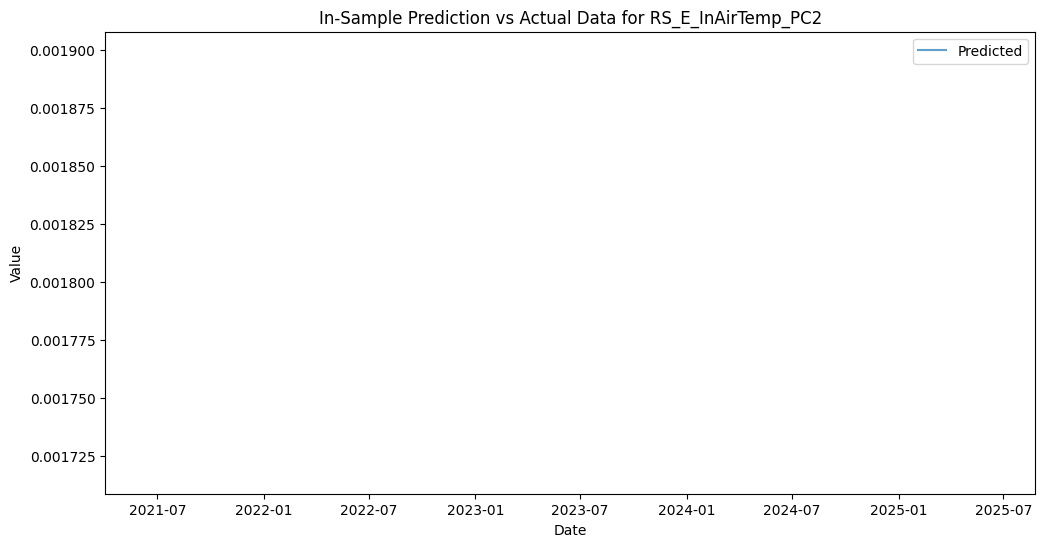

In [182]:
import matplotlib.pyplot as plt

# Select a single feature to plot (e.g., 'RS_E_InAirTemp_PC1')
feature_to_plot = 'RS_E_InAirTemp_PC2'

# Plot actual data
plt.figure(figsize=(12, 6))
#plt.plot(features_df[feature_to_plot], label='Actual')

# Plot predicted data
plt.plot(predicted_values[feature_to_plot], label='Predicted', alpha=0.7)

plt.title(f'In-Sample Prediction vs Actual Data for {feature_to_plot}')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


In [171]:
differenced_data

,RS_E_InAirTemp_PC1,RS_E_OilPress_PC1,RS_E_RPM_PC1,RS_E_WatTemp_PC1,RS_T_OilTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC2,RS_E_RPM_PC2,RS_E_WatTemp_PC2,RS_T_OilTemp_PC2,rolling_avg_speed,anomaly
timestamps_Belgian,,,,,,,,,,,,
2023-06-13 03:26:00+00:00,-1.000000,-10.500000,-24.000000,2.500000,0.000000,-1.000000,-10.500000,-9.500000,1.500000,0.000000,1.168183,0
2023-06-13 03:27:00+00:00,0.000000,-19.866638,0.900024,3.299999,1.299999,0.400000,-12.700012,0.299988,1.900002,-0.033333,19.779970,0
2023-06-13 03:28:00+00:00,0.700001,-15.466705,-1.500000,1.799999,0.133335,0.600000,-7.799988,-1.833313,1.199997,0.633331,37.275290,0
2023-06-13 03:29:00+00:00,0.299999,-12.291656,0.849976,1.650002,0.691666,0.000000,-10.875000,-0.466675,0.650002,0.275002,-37.319292,1
2023-06-13 03:30:00+00:00,0.000000,-21.375000,-8.250000,2.250000,1.375000,1.000000,-15.125000,1.500000,1.250000,-0.375000,-19.646550,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-13 06:40:00+00:00,2.000000,165.500000,912.500000,-1.000000,-1.000000,-2.000000,204.000000,902.000000,-2.500000,-1.000000,-10.798041,0
2023-06-13 06:41:00+00:00,2.500000,-22.500000,7.000000,4.000000,0.000000,3.500000,-23.000000,-2.500000,5.000000,0.000000,58.547126,0
2023-06-13 06:42:00+00:00,2.500000,-27.500000,-157.500000,1.000000,-0.500000,2.000000,-1.500000,-116.500000,-4.000000,-2.000000,39.103867,0


In [ ]:
# Load and preprocess the dataset
train_162['timestamps_Belgian'] = pd.to_datetime(train_162['timestamps_Belgian'])
train_162.set_index('timestamps_Belgian', inplace=True)

C:\Users\Hareem Raza\AppData\Local\Temp\ipykernel_10320\132167484.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  resampled_data_ffill = resampled_data.fillna(method='ffill')


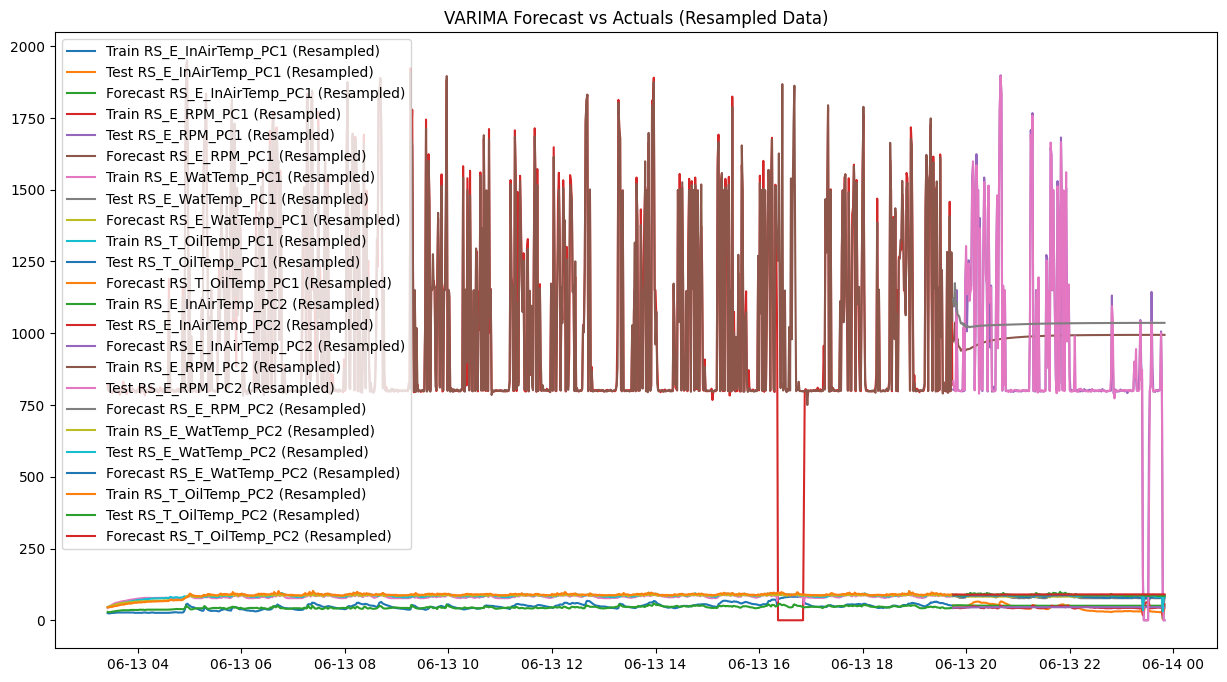

In [216]:
import pandas as pd
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Select features and resample the data
features = ['RS_E_InAirTemp_PC1', 'RS_E_RPM_PC1', 'RS_E_WatTemp_PC1', 
            'RS_T_OilTemp_PC1', 'RS_E_InAirTemp_PC2', 'RS_E_RPM_PC2', 
            'RS_E_WatTemp_PC2', 'RS_T_OilTemp_PC2']
data_model = train_162[features]
resampled_data = data_model.resample('1T').mean()
resampled_data_ffill = resampled_data.fillna(method='ffill')

# Split and build the VAR model on resampled data
train_resampled, test_resampled = train_test_split(resampled_data_ffill, test_size=0.2, shuffle=False)
model_resampled = VAR(endog=train_resampled)
selected_model_resampled = model_resampled.fit(maxlags=10, ic='aic')

# Forecast and plot
forecast_resampled_steps = len(test_resampled)
forecast_resampled = selected_model_resampled.forecast(train_resampled.values[-selected_model_resampled.k_ar:], steps=forecast_resampled_steps)
forecast_resampled_df = pd.DataFrame(forecast_resampled, index=test_resampled.index, columns=test_resampled.columns)

plt.figure(figsize=(15, 8))
for feature in features:
    plt.plot(train_resampled[feature], label=f'Train {feature} (Resampled)')
    plt.plot(test_resampled[feature], label=f'Test {feature} (Resampled)')
    plt.plot(forecast_resampled_df[feature], label=f'Forecast {feature} (Resampled)')
plt.title('VARIMA Forecast vs Actuals (Resampled Data)')
plt.legend()
plt.show()


In [217]:
import numpy as np

# Calculate the prediction error for each feature
error = test_resampled - forecast_resampled_df

# Calculate the standard deviation of the error
error_std = error.std()

# Anomaly detection threshold (can be adjusted as needed)
# Here, we're using a threshold of 2 standard deviations for demonstration
threshold = 2 * error_std

# Identify anomalies - An anomaly is flagged if the error exceeds the threshold for any feature
is_anomaly = (np.abs(error) > threshold).any(axis=1)

# Add an 'anomaly' column to the test set
test_resampled_with_anomaly = test_resampled.copy()
test_resampled_with_anomaly['anomaly'] = is_anomaly.astype(int)

# Display the modified test set with the anomaly column
test_resampled_with_anomaly.head(10)

,RS_E_InAirTemp_PC1,RS_E_RPM_PC1,RS_E_WatTemp_PC1,RS_T_OilTemp_PC1,RS_E_InAirTemp_PC2,RS_E_RPM_PC2,RS_E_WatTemp_PC2,RS_T_OilTemp_PC2,anomaly
timestamps_Belgian,,,,,,,,,
2023-06-13 19:45:00+00:00,51.5,803.5,85.0,86.5,43.0,833.0,87.0,89.5,0
2023-06-13 19:46:00+00:00,51.0,807.5,85.0,87.0,42.5,809.5,86.5,89.0,0
2023-06-13 19:47:00+00:00,51.0,800.5,84.5,86.5,43.0,801.5,87.0,88.0,0
2023-06-13 19:48:00+00:00,51.0,799.0,83.5,86.5,43.0,797.5,88.0,89.5,0
2023-06-13 19:49:00+00:00,50.5,1150.5,83.0,87.0,43.0,1075.5,87.5,89.0,0
2023-06-13 19:50:00+00:00,50.0,806.5,81.5,85.0,43.5,802.0,86.0,88.0,0
2023-06-13 19:51:00+00:00,50.0,800.0,80.0,85.0,43.0,799.0,86.5,88.5,0
2023-06-13 19:52:00+00:00,50.0,800.5,79.0,84.5,42.5,800.5,87.0,87.0,0
2023-06-13 19:53:00+00:00,50.0,798.5,78.0,83.0,42.0,799.5,88.0,87.5,0


In [218]:
test_resampled_with_anomaly.anomaly.value_counts()

anomaly
0    219
1     27
Name: count, dtype: int64

In [219]:
test_resampled_with_anomaly[test_resampled_with_anomaly['anomaly'] == 1]

,RS_E_InAirTemp_PC1,RS_E_RPM_PC1,RS_E_WatTemp_PC1,RS_T_OilTemp_PC1,RS_E_InAirTemp_PC2,RS_E_RPM_PC2,RS_E_WatTemp_PC2,RS_T_OilTemp_PC2,anomaly
timestamps_Belgian,,,,,,,,,
2023-06-13 20:05:00+00:00,55.000,1154.500000,90.000000,95.000000,46.000000,1143.00,89.500000,95.000000,1
2023-06-13 20:12:00+00:00,64.500,1624.000000,87.500000,90.500000,46.000000,1585.50,90.000000,92.000000,1
2023-06-13 20:39:00+00:00,60.500,1781.000000,88.000000,87.500000,48.500000,1781.50,87.000000,89.500000,1
2023-06-13 20:40:00+00:00,65.000,1898.500000,86.500000,88.000000,51.000000,1896.00,90.000000,89.500000,1
2023-06-13 20:41:00+00:00,66.000,1830.000000,88.500000,88.500000,50.000000,1834.00,88.000000,90.000000,1
2023-06-13 21:15:00+00:00,40.500,1708.000000,78.000000,82.000000,43.000000,1692.00,87.500000,88.500000,1
2023-06-13 21:17:00+00:00,52.500,1767.000000,83.000000,84.000000,52.000000,1758.00,88.500000,89.000000,1
2023-06-13 21:38:00+00:00,45.500,1646.000000,82.500000,88.000000,46.500000,1664.50,89.000000,92.500000,1
2023-06-13 21:41:00+00:00,50.000,1498.500000,86.000000,91.000000,48.000000,1499.50,91.000000,96.000000,1


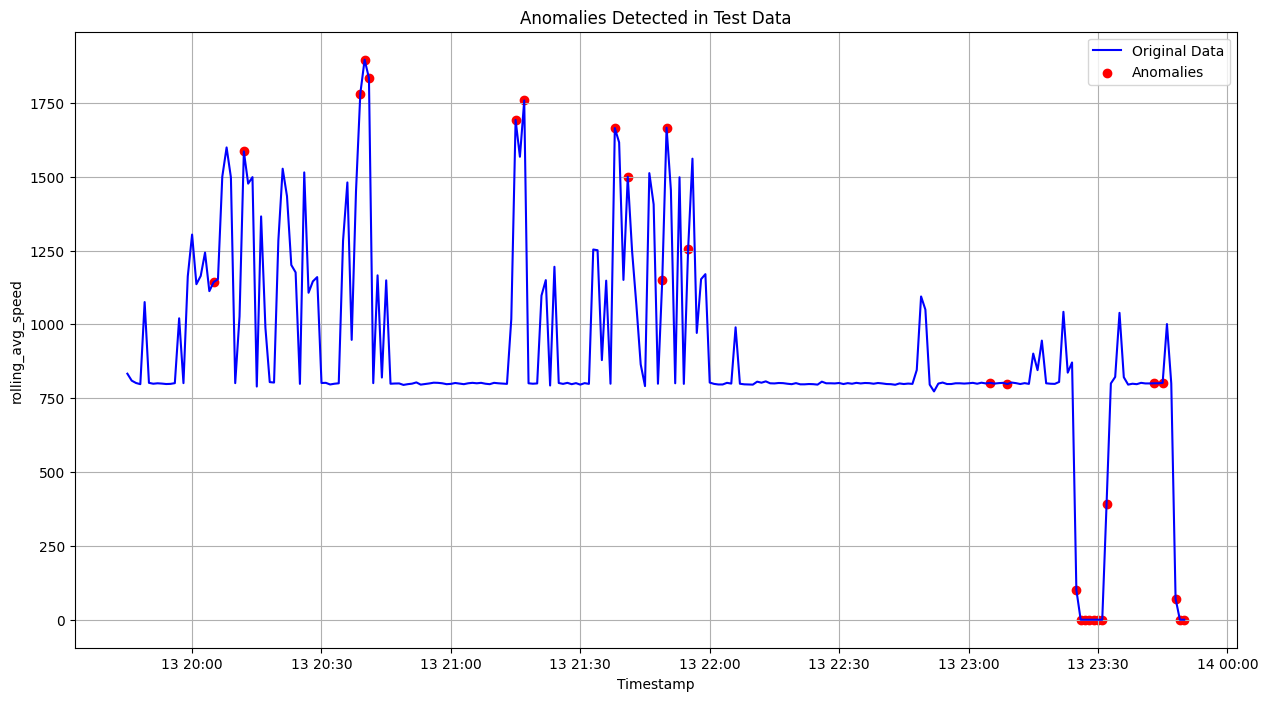

In [221]:
import matplotlib.pyplot as plt

# Plotting the anomalies
plt.figure(figsize=(15, 8))
plt.plot(test_resampled.index, test_resampled['RS_E_RPM_PC2'], label='Original Data', color='blue')
plt.scatter(test_resampled.index[is_anomaly], test_resampled['RS_E_RPM_PC2'][is_anomaly], color='red', marker='o', label='Anomalies')
plt.title('Anomalies Detected in Test Data')
plt.xlabel('Timestamp')
plt.ylabel('rolling_avg_speed')
plt.legend()
plt.grid(True)
plt.show()